<a href="https://colab.research.google.com/github/hridaykharpude/seed-i-fication/blob/main/seed-i-fication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For accessing the SeedIFication Project report access this link :
https://docs.google.com/document/d/15b7mVb6VWB7CPjK08nYMauNGyyXK-FEJcjheUCJc8Us/edit?usp=sharing

For any issues regarding accessing the file contact here:
No. : 9619047471  Mail ID : hridaysk@gmail.com

# Seedification ML Futureschool Project - Team 1

In [ ]:
#Importing All Necessary Libraries
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from numpy.random import rand
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from keras.optimizers import RMSprop, Adam, SGD
from keras.applications.inception_resnet_v2 import *
from PIL import Image
from PIL import ImageFilter
from collections import OrderedDict

In [ ]:
#Download dataset zip file from google drive
!gdown https://drive.google.com/u/0/uc?id=1rrUPO3O3HumiYjesilRyeayFer8Wv4kv&export=download

Downloading...
From: https://drive.google.com/u/0/uc?id=1rrUPO3O3HumiYjesilRyeayFer8Wv4kv
To: /content/dataset.zip
1.71GB [00:13, 130MB/s]


In [ ]:
#Unzip dataset zip file
!unzip -qq dataset.zip -d "/content/dataset/"

A# Exploratory Data Analysis

In [ ]:
#Creating List of all Classes. Titles
plant_types = ['Black-grass','Charlock','Cleavers','Common Chickweed','Common wheat','Fat Hen','Loose Silky-bent','Maize','Scentless Mayweed','Shepherds Purse','Small-flowered Cranesbill','Sugar beet']


In [ ]:
#Get the train and test data 
data_path = '/content/dataset/'

# Path of the dataset
train_dir = os.path.join(data_path,'train')
test_dir = os.path.join(data_path, 'test')

# Split the data into train and validation data
train_datagen=ImageDataGenerator(validation_split = 0.2) 

# We will use the same directory with a validation split of 0.2
train_generator=train_datagen.flow_from_directory(train_dir,target_size=(138,138),subset = 'training',color_mode = 'rgb',batch_size=32) #,shuffle = True
validation_generator=train_datagen.flow_from_directory(train_dir,target_size=(138,138),subset = 'validation', color_mode = 'rgb',batch_size=32) #,shuffle = True

#Get the class names
#class_names = train_generator.class_indices
# Used to map a numerical class to   the class label
#reverse_class = {j:i for i,j in class_names.items()}

Found 4432 images belonging to 12 classes.
Found 1102 images belonging to 12 classes.


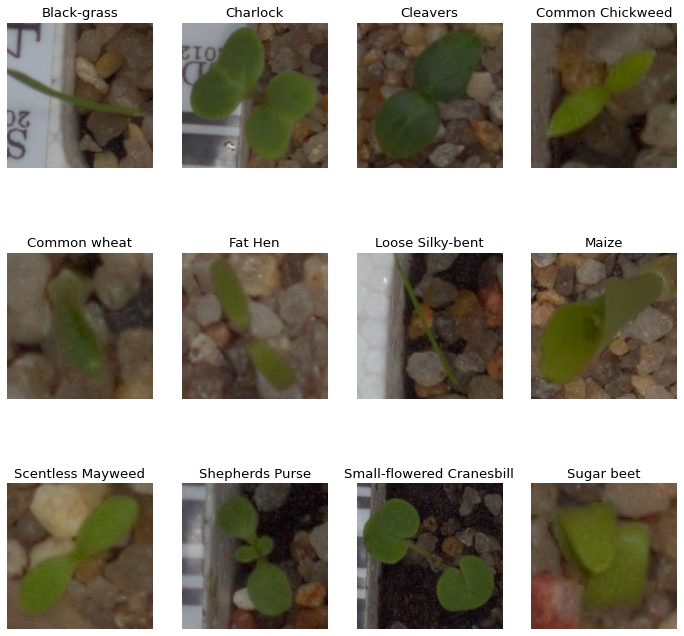

In [ ]:
#Present one image from each class
#Sets font size of plot text
plt.rcParams.update({'font.size': 11})

#Creating subplots for all images
fig,ax = plt.subplots(3,4, figsize=(12,12))

#Defining iterator
n=0

#Looping according to subplot index
for i in range(3):
  for j in range(4):
    #Deriving image file paths from earlier defined variables
    path = plant_types[n]
    ax[i][j].set_title(path)
    
    #Plotting images after reading from directory
    img = plt.imread(os.path.join('/content/dataset/train',path,'1.png'))
    ax[i][j].imshow(img)
    ax[i][j].axis('off')
    
    #Increasing iterator
    n+=1

In [ ]:
#Counting the number of images for each plant class

#Defining Empty List Variables
count=[]
plant=[]

for folder in sorted(os.listdir('/content/dataset/train')):
  #Takes length of all the image files combined, therefore returning count
  count.append(len(os.listdir('/content/dataset/train/'+folder)))
  #Creates a corresponding list of plant classes
  plant.append(folder)

#Printing count and plant classes
print(count)
print(plant)

[308, 452, 335, 712, 253, 537, 762, 257, 606, 274, 575, 463]
['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


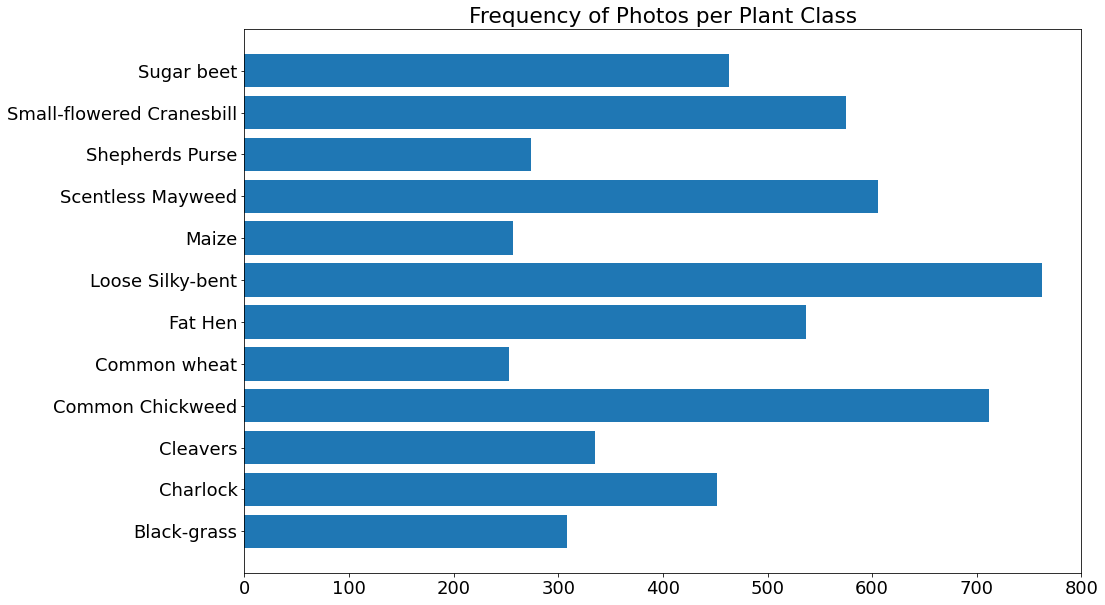

In [ ]:
#Plotting a horizontal bar plot of plant class distribution
#Sets font size of plot text, generate subplots and plot horizontal bar plot with title
plt.rcParams.update({'font.size': 18})
fig,ax = plt.subplots(figsize=(15,10))
plt.barh(plant,count)
plt.title("Frequency of Photos per Plant Class")
plt.show()

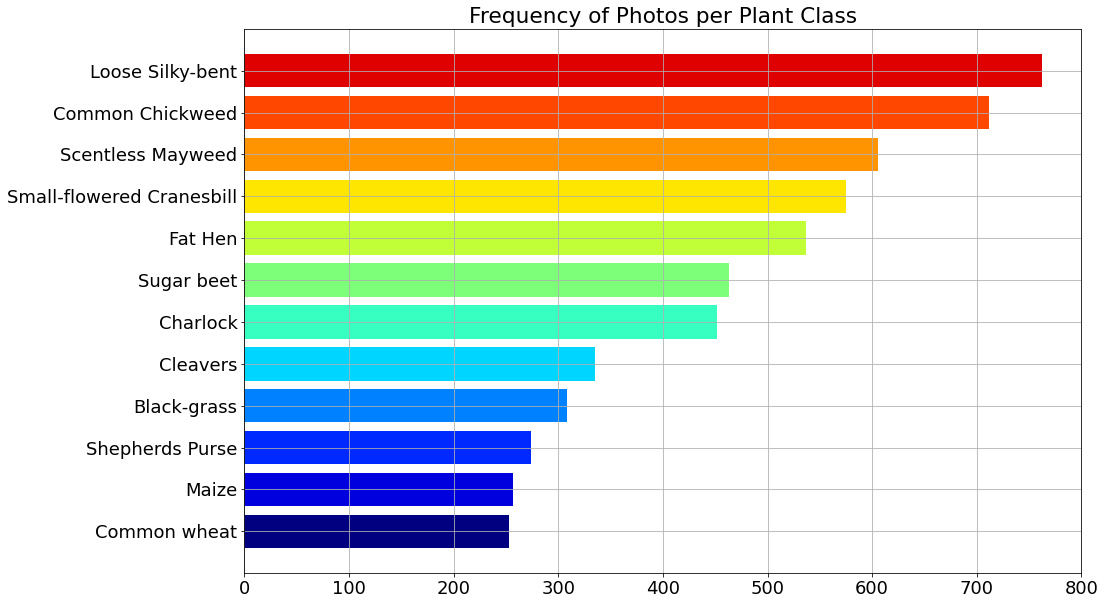

In [ ]:
#Plotting a colored horizontal bar plot of plant class distribution in descending order to show disparity clearly
#Sets font size of plot text
plantdict = dict(zip(count, plant))
ordered = OrderedDict(sorted(plantdict.items()))

#Sets font size of plot text and generates subplots
plt.rcParams.update({'font.size': 18})
fig,ax = plt.subplots(figsize=(15,10))

#List of numbers which are normalized to extract colours from the jet colourmap
data=[0,1,2,3,4,5,6,7,8,9,10,11]
my_cmap = cm.get_cmap('jet')
my_norm = Normalize(vmin=0, vmax=12)

#Plotting horizontal bar plot with gird, colours and descending order of image count and respective plant classes
plt.barh(list(ordered.values()),list(ordered.keys()),color=my_cmap(my_norm(data)))
plt.title("Frequency of Photos per Plant Class")
plt.grid()
plt.show()

#Image segmentation

In [ ]:
#Create dataframe of filepaths and plant classes for reference
train_data = []
for plant_types_id, sp in enumerate(plant_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['/content/dataset/train/{}/{}'.format(sp, file), plant_types_id, sp])

train = pd.DataFrame(train_data, columns=['File', 'plant_typesid','plant_types'])

In [ ]:
#Standardize image size
IMAGE_SIZE = 138

#Read image function
def read_image(filepath):
    return cv2.imread(os.path.join(data_path, filepath)) # Loading a color image is the default flag

# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)
  

In [ ]:
#Mask Function
def create_mask(image):
    # Convert from BGR to HSV color-space to extract colored object
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # Define range of green in HSV
    lower_green = np.array([30, 100, 50])
    upper_green = np.array([85, 255, 255])
    # Threshold the HSV image to get only green colors
    mask = cv2.inRange(image_hsv, lower_green, upper_green)
    # We will use a morphological operation called closing to close small holes in the image
    # We need a kernel or structuring element to determine the nature of the operation
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return mask

#output Segmented image using mask
def segment_image(image):
    mask = create_mask(image)
    res = cv2.bitwise_and(image, image, mask=mask) # Bitwise-AND mask and original image
    return res

In [ ]:
#combined Segmentation preprocessing function compatible with ImageDataGenerator
def segmenter(image):
    image_masked = create_mask(image)
    image_segmented = segment_image(image)
    image_resized = resize_image(image_segmented, (IMAGE_SIZE, IMAGE_SIZE))
    plt.imshow(image_resized)
    return image_resized

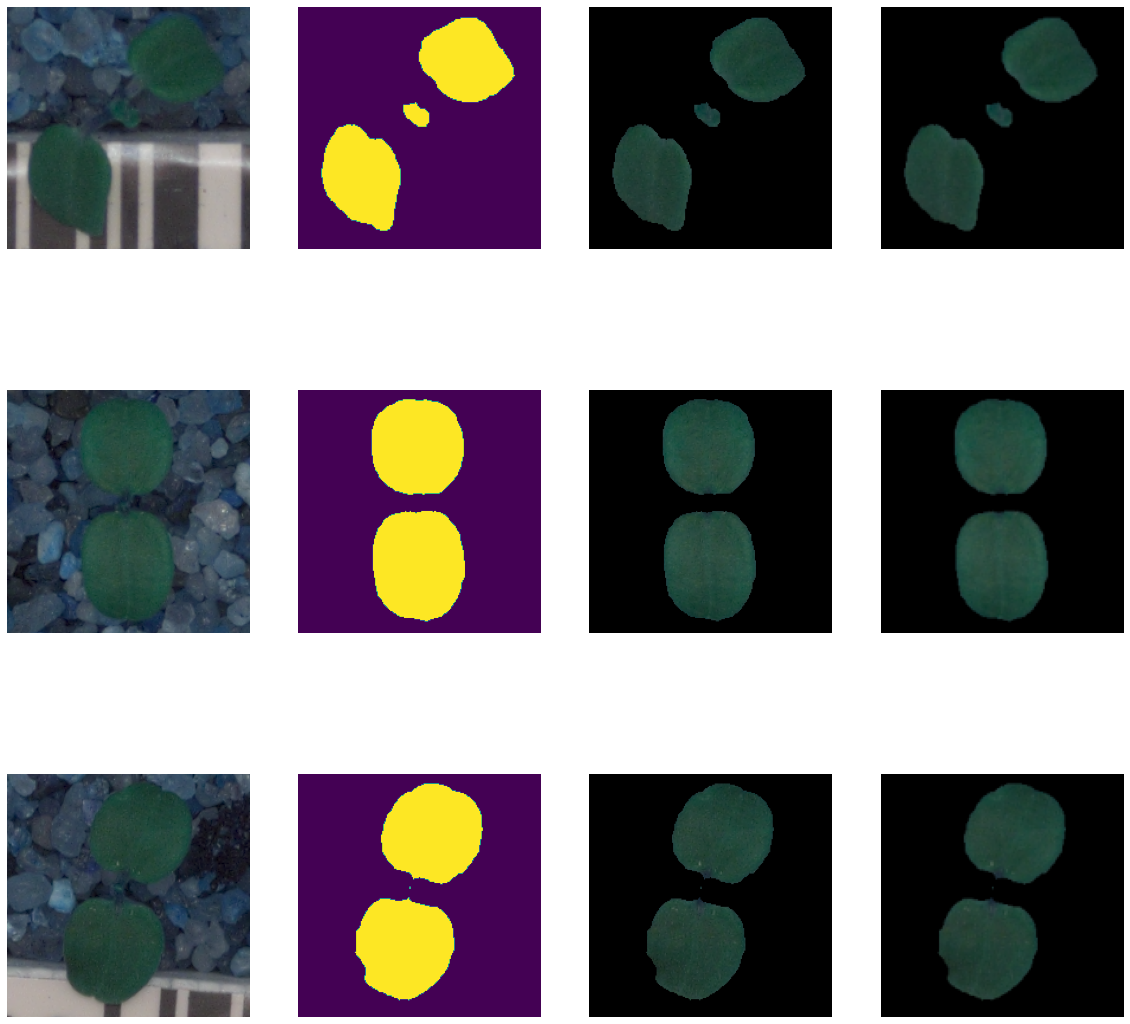

In [ ]:
#
def show_segmented_images(plant_types, n):
    fig, ax = plt.subplots(n, 4, figsize=(20, 20))
    plant_types_files = train['File'][train['plant_types'] == plant_types].values
    for i in range(n):
        image = read_image(plant_types_files[i])
        image_masked = create_mask(image)
        image_segmented = segment_image(image)
        image_resized = resize_image(image_segmented, (IMAGE_SIZE, IMAGE_SIZE))
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
        ax[i, 2].set_axis_off()
        ax[i, 3].set_axis_off()
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(image_masked)
        ax[i, 2].imshow(image_segmented)
        ax[i, 3].imshow(image_resized)
# Displays first n images of class from training set
show_segmented_images('Cleavers', 3)

Sugar beet
Scentless Mayweed
Common wheat
Black-grass
Cleavers
Loose Silky-bent
Small-flowered Cranesbill
Maize
Common Chickweed
Shepherds Purse
Charlock
Fat Hen


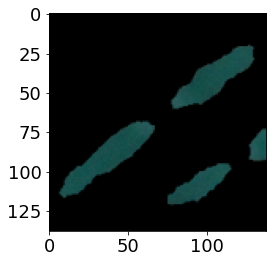

In [ ]:
#This function replaces all the original image data with segmented data
def segmentdirectory():
    for folder in os.listdir('/content/dataset/train'):
        print(folder)
        for image in os.listdir('/content/dataset/train/'+folder):
            inputPath = os.path.join(('/content/dataset/train/'+folder), image)
            img = cv2.imread(inputPath)
            segmented_img = segmenter(img)
            cv2.imwrite(inputPath, segmented_img)
segmentdirectory()

In [ ]:
#This code creates a dataframe with filepaths and corresponding plant type classes but limits only 253 per class
train_data = []
for plant_types_id, sp in enumerate(plant_types):
    count = 0
    for file in os.listdir(os.path.join(train_dir, sp)):
        count += 1
        if count >= 254: continue
        train_data.append(['/content/dataset/train/{}/{}'.format(sp, file), plant_types_id, sp])

train = pd.DataFrame(train_data, columns=['File', 'plant_typesid','plant_types'])

In [ ]:
#Defining Seed
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices

In [ ]:
#Defining ImageDataGenerator for segmented data
train_dgen = ImageDataGenerator(validation_split=0.2)
train_gen = train_dgen.flow_from_dataframe(train, x_col='File', y_col='plant_types', target_size=(138,138),subset = 'training', batch_size=32)
val_gen = train_dgen.flow_from_dataframe(train, x_col='File', y_col='plant_types', target_size=(138,138),subset = 'validation', batch_size=32)

Found 2429 validated image filenames belonging to 12 classes.
Found 607 validated image filenames belonging to 12 classes.


# Building a Convolutional Neural Network

 **Alternate (previously tried) Models**
 

In [ ]:
#img_size=(138,138)

#model = Sequential()
#model.add(Conv2D(32,kernel_size=(3,3),input_shape=(138,138,3),activation='relu'))
#model.add(Conv2D(32,kernel_size=(3,3), activation='relu', padding='same'))
#model.add(MaxPool2D(2,2))
#model.add(Dropout(0.1))
#model.add(Conv2D(64,kernel_size=(3,3), activation='relu'))
#model.add(Conv2D(64,kernel_size=(3,3),activation='relu', padding='same'))
#model.add(MaxPool2D(2,2))
#model.add(Dropout(0.15))
#model.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
#model.add(MaxPool2D(2,2))
#model.add(Dropout(0.2))
#model.add(Flatten())
#model.add(Dense(256, activation='relu'))
#model.add(Dense(12, activation='softmax'))

#model.summary()

#model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.9, beta_2=0.999), metrics=['accuracy'])
#history = model.fit(train_generator, validation_data=validation_generator, epochs=20)

**Final Model**

In [ ]:
#Importing layers of InceptionResnetV2 to ResNetV2
ResNetV2 = InceptionResNetV2(include_top=False, weights='imagenet', pooling = 'avg', input_shape=(138,138,3))

#Checking the output shape of the imported model
ResNetV2.output_shape

219070464/219055592 [==============================] - 1s 0us/step


(None, 1536)

In [ ]:
#Creating a new model : "mode_final"
#Adding Dense layers and Dropout to the model
model_final = Sequential([ResNetV2, 
                         Dense(128, activation = 'relu'),
                         #BatchNormalization(),
                         Dropout(0.25),
                         Dense(12, activation = 'softmax')])

#Creating an optimizer variable
adam = Adam(learning_rate=0.0003, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) 

#Creating a Callback variable
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2,verbose=1)

#Taking a look at the model layers
model_final.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 1536)              54336736  
_________________________________________________________________
dense_2 (Dense)              (None, 128)               196736    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 12)                1548      
Total params: 54,535,020
Trainable params: 54,474,476
Non-trainable params: 60,544
_________________________________________________________________


In [ ]:
#Compiling model and preparing for training
model_final.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

In [ ]:
#Creating epoch and batch_size variable for easy manipulation of model training
epochs=20
batch_size = 32

#Training model using .fit

#use train_generator and validation_generator for nonsegmented (original) data
#history = model_conv.fit(train_generator,validation_data=validation_generator,callbacks=[lr],batch_size=batch_size , epochs=epochs)

#use train_gen and val_gen for training model on Segmented Data
history = model_final.fit(train_gen,validation_data=val_gen,callbacks=[lr],batch_size=batch_size , epochs=epochs)

Epoch 1/20
76/76 [==============================] - 19s 253ms/step - loss: 0.0114 - accuracy: 0.9979 - val_loss: 0.2751 - val_accuracy: 0.9242
Epoch 2/20
76/76 [==============================] - 20s 260ms/step - loss: 0.0109 - accuracy: 0.9975 - val_loss: 0.2748 - val_accuracy: 0.9242
Epoch 3/20
76/76 [==============================] - 20s 257ms/step - loss: 0.0103 - accuracy: 0.9963 - val_loss: 0.2738 - val_accuracy: 0.9242

Epoch 00003: ReduceLROnPlateau reducing learning rate to 3.000000248221113e-09.
Epoch 4/20
76/76 [==============================] - 20s 258ms/step - loss: 0.0093 - accuracy: 0.9979 - val_loss: 0.2732 - val_accuracy: 0.9242
Epoch 5/20
76/76 [==============================] - 20s 263ms/step - loss: 0.0107 - accuracy: 0.9988 - val_loss: 0.2731 - val_accuracy: 0.9275
Epoch 6/20
76/76 [==============================] - 20s 263ms/step - loss: 0.0098 - accuracy: 0.9979 - val_loss: 0.2731 - val_accuracy: 0.9259
Epoch 7/20
76/76 [==============================] - 20s 261ms

In [ ]:
#Plotting Training and Validation values of Accuracy and Loss for Model
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.legend(['Validation Loss','Train Loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.show()